In [1]:
import sys
sys.path.append("../modules")
import numpy as np
from numpy.linalg import inv, norm
from astropy import units as u
from datetime import datetime
from numba import jit
from scipy.optimize import minimize, fsolve, newton
from poliastro.bodies import Earth
from poliastro.twobody import Orbit
from poliastro.plotting import *
from poliastro.constants import J2000
from poliastro.util import time_range
from datetime import datetime, timedelta
import plotly.io as pio
pio.renderers.default = "vscode"
from orbit_module import get_orbit, tle_data, create_rso, rv_sample
from observation import rv_observation, collision_model, objective, mass_constraint1, \
    mass_constraint2, velocity_constraint, partial_Lagrangian, hessian_lagrangian, svdinv, lagrangian
from astropy.constants import G, M_earth
import matplotlib.pyplot as plt
from astropy import time
from astropy.coordinates import EarthLocation, AltAz
import astropy.coordinates as coord
from autograd import grad

mu = G*M_earth

## Load TLE

In [2]:
epoch = time.Time('2021-06-7 12:00:00', format='iso', scale='utc')
active_sat = get_orbit('NOAA 15')

TypeError: get_orbit() missing 1 required positional argument: 'TLE'

In [48]:
delt = epoch - active_sat.epoch
active_sat_prop = active_sat.propagate(delt)
rso_bc = create_rso(active_sat_prop, [0.5, 0, 0]*u.km/u.s)


## $\Delta V$ calculation

In [49]:
m_rso = 0.5*u.kg
m_sat = 2*u.kg

collision = collision_model(m_sat, m_rso, active_sat_prop, rso_bc)

rso_ac = create_rso(rso_bc, collision.delta_v_rso)
active_sat_ac = create_rso(active_sat_prop, collision.delta_v_sat)
print("Collision outcome")
print("\nActive satellite delta-v:", collision.delta_v_sat)
print("\nRSO delta-v             :", collision.delta_v_rso)

Collision outcome

Active satellite delta-v: [0.2 0.  0. ] km / s

RSO delta-v             : [-8.000e-01  4.441e-16  2.220e-16] km / s


In [50]:
frame = OrbitPlotter3D()
frame.plot(active_sat_prop, label = 'sat')
frame.plot(rso_bc, label = 'RSO before')
frame.plot(rso_ac, label = 'RSO after')
frame.plot(active_sat_ac, color = 'black', label = 'sat after')

## Collision trajectory generation

In [51]:
rv_sat_normal = rv_sample(active_sat_prop, -30*u.min, 30*u.min, 100)
rv_sat_coll = rv_sample(active_sat_prop, -30*u.min, 30*u.min, 100, orbit_ac = active_sat_ac)

rv_rso_normal = rv_sample(rso_bc, -30*u.min, 30*u.min, 100)
rv_rso_coll = rv_sample(rso_bc, -30*u.min, 30*u.min, 100, orbit_ac = rso_ac)

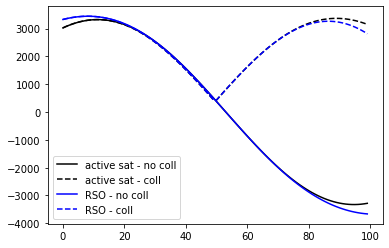

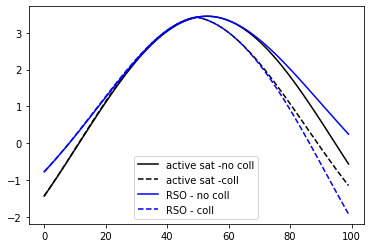

In [52]:
%matplotlib inline
axs = 1
plt.figure()
plt.plot(rv_sat_normal.r[:,axs], 'k', label = 'active sat - no coll')
plt.plot(rv_sat_coll.r[:,axs], '--k', label = 'active sat - coll')

plt.plot(rv_rso_normal.r[:,axs], 'b', label = 'RSO - no coll')
plt.plot(rv_rso_coll.r[:,axs], '--b', label = 'RSO - coll')
plt.legend()

plt.figure()
plt.plot(rv_sat_normal.v[:,axs], 'k', label = 'active sat -no coll')
plt.plot(rv_sat_coll.v[:,axs], '--k', label = 'active sat -coll')

plt.plot(rv_rso_normal.v[:,axs], 'b', label = 'RSO - no coll')
plt.plot(rv_rso_coll.v[:,axs], '--b', label = 'RSO - coll')
plt.legend()

## Observation generation

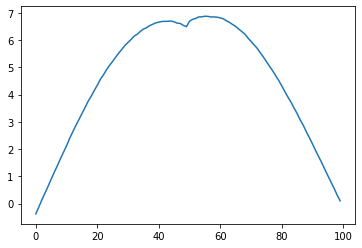

In [53]:
# Tracking observation
r_sigma = 1
v_sigma = 0.01
observation = rv_observation(rv_sat_coll, r_sigma, v_sigma)
plt.plot(observation.v[:,0])


# Using Scipy optimize 

In [54]:
Z = np.zeros(6)
Z[0:3] = collision.sat.r.value
Z[3:6] = collision.delta_v_sat.value + 0.1*np.random.randn(3)
np.set_printoptions(precision=3)

con1 = {'type': 'ineq', 'fun': mass_constraint1}
con2 = {'type': 'ineq', 'fun': mass_constraint2}
con3 = {'type': 'ineq', 'fun': velocity_constraint}
cons = ([con1, con2, con3])
X0 = np.zeros([7,1])
X0[0:3] = np.reshape(collision.sat.r.value, (3,1))
X0[3:6] = np.reshape(collision.sat.v.value, (3,1))
X0[6] = 0.01

solution = minimize(objective, X0, args = (Z, collision), method='SLSQP', constraints= cons)
print('solution:\n', solution.x)
print("postion error:", rso_bc.r.value - solution.x[0:3])
print("velocity error:", rso_bc.v.value - solution.x[3:6])

rso_estimate = Orbit.from_vectors(Earth, solution.x[0:3]*u.km, solution.x[3:6]*u.km/u.s, active_sat_prop.epoch)
frame = OrbitPlotter3D()
frame.plot(rso_bc, label = 'RSO before')
frame.plot(rso_estimate, label = 'RSO est')

solution:
 [-1.533e+03  4.368e+02  7.011e+03  6.576e+00  3.292e+00  1.165e+00
  1.000e+00]
postion error: [-1.975e-05  4.188e-06  8.732e-05]
velocity error: [0.425 0.123 0.043]


# Using Lagrange Multiplier

In [79]:
X0[0:3] = np.reshape(collision.sat.r.value, (3,1))
X0[3:6] = np.reshape(collision.sat.v.value, (3,1))
X0[6] = 1

Z = np.zeros(6)
Z[0:3] = collision.sat.r.value + 0.5*np.random.randn(3)
Z[3:6] = collision.delta_v_sat.value + 0.1*np.random.randn(3)
np.set_printoptions(precision=3)

L0 = np.zeros([9,1])

L0[0:7] = X0
L0[7] = 0.8
L0[8] = 0.8
#L0[9] = 0.1

L = L0
gamma = 0.001
for i in range(0,100):
    #if i > 0:
    #    delta = g -g_
    #    gamma = norm((L - L_).T.dot(delta))/norm(delta) 
    
    L_ = L
    g_ = partial_Lagrangian(L_, Z, collision)  
      
    L = L - gamma*g_
    g = partial_Lagrangian(L, Z, collision)
    cost = lagrangian(L, Z, collision)
    if  norm(g)< 0.01:
        print("Iteration:", i, "LR: ", gamma)
        print("Lagrangian: ", cost)
        print("gradient:")
        print(g)
        break
rd_est = L[0:3]
vd_est = L[3:6]
md_est = L[6]

print("postion error:", rso_bc.r.value - rd_est.flatten())
print("velocity error:", rso_bc.v.value - vd_est.flatten())
print("Mass error:", m_rso.value - md_est)
print("Mass: ", md_est, "kg")

rso_estimate_lag = Orbit.from_vectors(Earth, rd_est.flatten()*u.km, vd_est.flatten()*u.km/u.s, active_sat_prop.epoch)
frame1 = OrbitPlotter3D()
frame1.plot(rso_bc, label = 'RSO before')
frame1.plot(rso_estimate_lag, label = 'RSO est')
frame1.plot(rso_estimate, label = 'RSO scipy')
frame1.plot(active_sat_prop, label = 'sat')

Iteration: 6 LR:  0.001
Lagrangian:  [1.904]
gradient:
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]
postion error: [0. 0. 0.]
velocity error: [ 0.5    0.    -0.001]
Mass error: [-0.501]
Mass:  [1.001] kg


# Testing objectives

In [81]:
Z0 = np.zeros(6)
Z0[0:3] = collision.sat.r.value
Z0[3:6] = collision.delta_v_sat.value

X_true = np.zeros([7, 1])
X_true[0:3] = np.array([rso_bc.r.value]).T
X_true[3:6] = np.array([rso_bc.v.value]).T
X_true[6] = m_rso

objective(L[0:7], Z0, collision)

0.04000044503703704

In [82]:
0.6*np.random.randn(3)

array([ 0.058, -0.148, -0.048])